In [1]:
from sklearn.preprocessing import StandardScaler
import pyupbit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import shap
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf 
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf 
from statsmodels.regression.linear_model import yule_walker 
import matplotlib.pyplot as plt 
import numpy as np 
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

In [16]:
# 데이터 로드
ticker = 'KRW-BTC'
interval = 'minute3'
to = '2024-10-31 09:00'
count = 13440
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
# 이동평균 3과 5 계산
data['ma_3'] = data['close'].rolling(window=3).mean()  # 3-period 이동평균
data['ma_5'] = data['close'].rolling(window=5).mean()  # 5-period 이동평균
data['middle'] = (data['high'] + data['low']) / 2

#1달 데이터 3분간격

In [17]:
# NaN 값 제거 (초기 구간에서는 이동평균 계산 불가)
data = data.dropna()

In [18]:
data

,open,high,low,close,volume,value,ma_3,ma_5,middle
2024-10-03 12:39:00,82505000.0,82505000.0,82427000.0,82505000.0,2.966659,2.447083e+08,8.253700e+07,82558400.0,82466000.0
2024-10-03 12:42:00,82500000.0,82505000.0,82423000.0,82499000.0,1.690431,1.393662e+08,8.249833e+07,82546000.0,82464000.0
2024-10-03 12:45:00,82499000.0,82593000.0,82433000.0,82482000.0,3.699225,3.052489e+08,8.249533e+07,82518400.0,82513000.0
2024-10-03 12:48:00,82590000.0,82591000.0,82500000.0,82589000.0,0.558138,4.609081e+07,8.252333e+07,82513200.0,82545500.0
2024-10-03 12:51:00,82590000.0,82610000.0,82540000.0,82609000.0,2.760618,2.280237e+08,8.256000e+07,82536800.0,82575000.0
...,...,...,...,...,...,...,...,...,...
2024-10-31 17:45:00,100419000.0,100445000.0,100402000.0,100416000.0,1.881093,1.888933e+08,1.004213e+08,100428200.0,100423500.0
2024-10-31 17:48:00,100416000.0,100454000.0,100401000.0,100416000.0,2.048091,2.056766e+08,1.004170e+08,100426000.0,100427500.0
2024-10-31 17:51:00,100416000.0,100479000.0,100401000.0,100451000.0,2.179007,2.188510e+08,1.004277e+08,100426200.0,100440000.0
2024-10-31 17:54:00,100451000.0,100541000.0,100451000.0,100541000.0,2.542313,2.554695e+08,1.004693e+08,100448600.0,100496000.0


In [31]:
X=data.iloc[:,:-1]
y=data.iloc[:,8:9]
print(X)
print(y)

                            open         high          low        close  \
2024-10-03 12:39:00   82505000.0   82505000.0   82427000.0   82505000.0   
2024-10-03 12:42:00   82500000.0   82505000.0   82423000.0   82499000.0   
2024-10-03 12:45:00   82499000.0   82593000.0   82433000.0   82482000.0   
2024-10-03 12:48:00   82590000.0   82591000.0   82500000.0   82589000.0   
2024-10-03 12:51:00   82590000.0   82610000.0   82540000.0   82609000.0   
...                          ...          ...          ...          ...   
2024-10-31 17:45:00  100419000.0  100445000.0  100402000.0  100416000.0   
2024-10-31 17:48:00  100416000.0  100454000.0  100401000.0  100416000.0   
2024-10-31 17:51:00  100416000.0  100479000.0  100401000.0  100451000.0   
2024-10-31 17:54:00  100451000.0  100541000.0  100451000.0  100541000.0   
2024-10-31 17:57:00  100540000.0  100570000.0  100540000.0  100559000.0   

                       volume         value          ma_3         ma_5  
2024-10-03 12:39:00  2.966

In [32]:
ms = MinMaxScaler()
ss = StandardScaler()

# 데이터 분리
SPLIT = int(0.7 * len(data))  # 7:3으로 분할

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y) 

X_train = X_ss[:SPLIT, :]
X_test = X_ss[SPLIT:, :]

y_train = y_ms[:SPLIT, :]
y_test = y_ms[SPLIT:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (9405, 8) (9405, 1)
Testing Shape (4031, 8) (4031, 1)


In [33]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([9405, 1, 8]) torch.Size([9405, 1])
Testing Shape torch.Size([4031, 1, 8]) torch.Size([4031, 1])


In [34]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=True, batch_first=True) 
        self.fc =  nn.Linear(hidden_size*2, num_classes) 
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))                 
        out, _ = self.lstm(x, (h_0, c_0)) 
        out = self.fc(out[:, -1, :])               
        out = self.relu(out)
        return out

In [35]:
num_epochs = 2000
learning_rate = 0.0001 

input_size = 8
hidden_size = 4 
num_layers = 1 

num_classes = 1 
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [94]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)


biLSTM(
  (lstm): LSTM(8, 4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [95]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad() 
 
    loss = criterion(outputs, y_train_tensors) 
    loss.backward()  
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.13241
Epoch: 100, loss: 0.07237
Epoch: 200, loss: 0.04615
Epoch: 300, loss: 0.03756
Epoch: 400, loss: 0.03380
Epoch: 500, loss: 0.03148
Epoch: 600, loss: 0.02975
Epoch: 700, loss: 0.02839
Epoch: 800, loss: 0.02721
Epoch: 900, loss: 0.02610
Epoch: 1000, loss: 0.02527
Epoch: 1100, loss: 0.02464
Epoch: 1200, loss: 0.02413
Epoch: 1300, loss: 0.02371
Epoch: 1400, loss: 0.02329
Epoch: 1500, loss: 0.02293
Epoch: 1600, loss: 0.02264
Epoch: 1700, loss: 0.02238
Epoch: 1800, loss: 0.02213
Epoch: 1900, loss: 0.02190


In [96]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

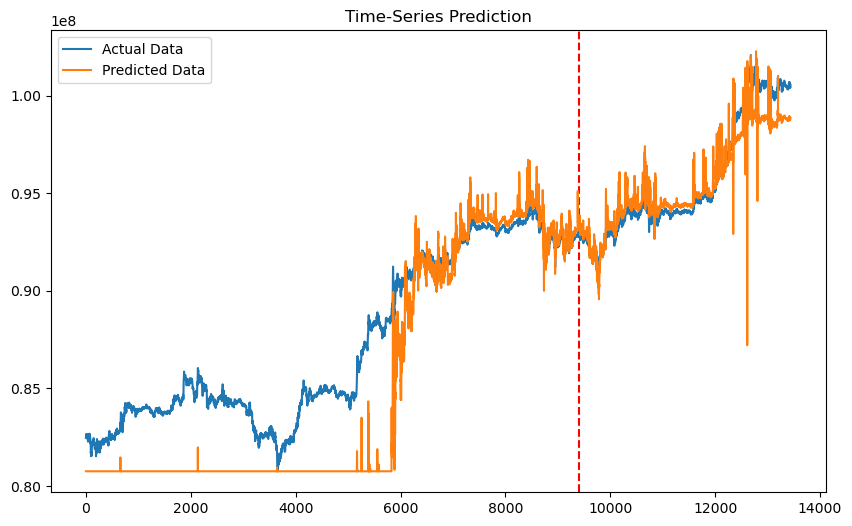

In [97]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=SPLIT, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

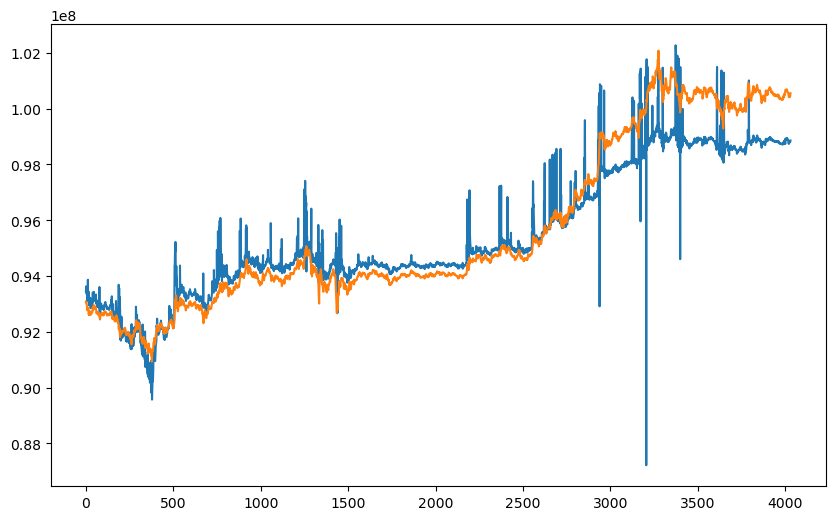

In [98]:
plt.figure(figsize=(10,6)) 
plt.plot(predicted[SPLIT:, :], label='Predicted Data') 
plt.plot(label_y[SPLIT:, :], label='Predicted Data') 

In [99]:
def calculate_metrics(pred, true):
    """
    MAE, MSE, RMSE, MAPE, MSPE 계산
    :param pred: 예측값 (1D array)
    :param true: 실제값 (1D array)
    :return: 각 지표의 값
    """
    mae = np.mean(np.abs(pred - true))  # Mean Absolute Error
    mse = np.mean((pred - true) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mape = np.mean(np.abs((true - pred) / true)) * 100  # Mean Absolute Percentage Error
    mspe = np.mean(((true - pred) / true) ** 2) * 100  # Mean Squared Percentage Error

    return mae, mse, rmse, mape, mspe


In [100]:
true = label_y
pred = predicted

In [101]:
# 평가 지표 계산
mae, mse, rmse, mape, mspe = calculate_metrics(pred, true)

# 결과 출력
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSPE: {mspe:.4f}%")

MAE: 1929910.5000
MSE: 7171819962368.0000
RMSE: 2678025.5000
MAPE: 2.22%
MSPE: 0.0961%
